In [114]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
from scipy.stats import entropy, wasserstein_distance, skew, kurtosis
from dtaidistance import dtw
from numba import njit, prange
import random
from mpl_toolkits.mplot3d import Axes3D
import bisect

solargen = pd.read_excel('./data/Belgium_solar_generation_probability_density.xlsx', sheet_name='Solar_profiles',header=None)
solargen = solargen
solargen = solargen.drop(index=0, columns=0).reset_index(drop=True)
solargen.index = range(1, len(solargen) + 1)
solargen = solargen.iloc[:, :-1]
solargen_kwh = solargen/4

# Select small consumer = 1000 kWh, medium consumer = 2500 kWh, large consumer = 6500 kWh
consumer1 = pd.read_csv('./data/Fluvius load profiles type 1 consumer/Type1consumerLoad57.csv', header=None)
consumer1.columns = range(1, consumer1.shape[1] + 1)
consumer1.index = range(1, len(consumer1) + 1)

consumer2 = pd.read_csv('./data/Fluvius load profiles type 1 consumer/Type1consumerLoad940.csv', header=None)
consumer2.columns = range(1, consumer2.shape[1] + 1)
consumer2.index = range(1, len(consumer2) + 1)

consumer3 = pd.read_csv('./data/Fluvius load profiles type 1 consumer/Type1consumerLoad234.csv', header=None)
consumer3.columns = range(1, consumer3.shape[1] + 1)
consumer3.index = range(1, len(consumer3) + 1)

charging_profiles_folder = "./data/Charging profiles/"

charging_profiles_files = [os.path.join(charging_profiles_folder, f) for f in os.listdir(charging_profiles_folder) if f.endswith('.csv')]
charging_profiles_dict = {}
for file in charging_profiles_files:
    power_input = float(file.split('_')[-1].replace('kW.csv', ''))
    charging_profile = pd.read_csv(file, header=None).iloc[1:, 1:].reset_index(drop=True) 
    charging_profile.index = range(1, len(charging_profile) + 1)
    charging_profiles_dict[power_input] = charging_profile


In [115]:
charging_profiles_dict[0] = 0*charging_profiles_dict[0.1]
display(charging_profiles_dict[0].min().min())

0.0

In [116]:
def metrics(consumer):
    step = 0.1
    kwp_set = np.arange(0, 5+step, step)
    kw_set = np.arange(0, 7+step, step)
    kw_set = [round(elem, 1) for elem in kw_set]
    kwp_set = [round(elem, 1) for elem in kwp_set]

    nb_kwp = len(kwp_set)
    nb_kw = len(kw_set)

    matrix_min = np.zeros((nb_kwp, nb_kw))
    matrix_max = np.zeros((nb_kwp, nb_kw))
    matrix_mean = np.zeros((nb_kwp, nb_kw))
    matrix_std = np.zeros((nb_kwp, nb_kw))
    matrix_skew = np.zeros((nb_kwp, nb_kw))
    matrix_kurt = np.zeros((nb_kwp, nb_kw))
    matrix_var = np.zeros((nb_kwp, nb_kw))

    matrix_load = np.zeros((nb_kwp, nb_kw))
    matrix_q5 = np.zeros((nb_kwp, nb_kw))
    matrix_q95 = np.zeros((nb_kwp, nb_kw))

    # matrix_entropy = np.zeros((nb_kwp, nb_kw))
    # matrix_KL = np.zeros((nb_kwp, nb_kw))
    # matrix_total_distance = np.zeros((nb_kwp, nb_kw))
    # matrix_wasserstein_distance = np.zeros((nb_kwp, nb_kw))


    for i, kwp in enumerate(kwp_set):
        print('iteration :', i, ' of ', nb_kwp)
        for j, kw in enumerate(kw_set):
            if kw == 0:
                chargingprofile = 0*charging_profiles_dict[0.1]
            else:
                chargingprofile = charging_profiles_dict[kw]
            chargingprofile = chargingprofile.fillna(0)
            net_load = consumer*4 - kwp*solargen + chargingprofile
            net_load = net_load/4

            matrix_min[i,j] = net_load.min().min()
            matrix_max[i,j] = net_load.max().max()
            matrix_mean[i,j] = net_load.mean().mean()
            matrix_load[i,j] = net_load.sum().sum()
            matrix_q5[i,j] = pd.Series(net_load.values.flatten()).quantile(.05)
            matrix_q95[i,j] = pd.Series(net_load.values.flatten()).quantile(.95)
        
            matrix_std[i,j] = (net_load.std(axis=0,ddof=0)).sum()/365
            matrix_skew[i,j] = (net_load.skew(axis=0)).sum()/365
            matrix_kurt[i,j] = (net_load.kurt(axis=0)).sum()/365
            matrix_var[i,j] = (net_load.var(axis=0)).sum()/365


            # #Compute common bin width
            # hist_base, bin_edges_base = np.histogram(consumer_flat,bins='auto',density=False)
            # bin_width = bin_edges_base[1] - bin_edges_base[0]
            # adjusted_min = consumer_flat.min()
            # while adjusted_min > net_load.min():
            #     adjusted_min -= bin_width
            # adjusted_max = consumer_flat.max()
            # while adjusted_max < net_load.max():
            #     adjusted_max += bin_width

            # bin_edges_net_load = np.arange(adjusted_min, adjusted_max + bin_width, bin_width)
            # bin_edges_net_load = [ round(elem, 5) for elem in bin_edges_net_load ]
            # bin_edges_base = [ round(elem, 5) for elem in bin_edges_base ]

            # hist_net_load, _ = np.histogram(net_load,bins=bin_edges_net_load,density=False)

            # # Compute histograms

            # # hist_net_load, bin_edges_net = np.histogram(net_load,bins=bin_edges_net_load,density=True)
            # # hist_base, bin_edges_base = np.histogram(consumer1,bins=bins,range=(global_min,global_max),density=True)
            
            # # Turn hist into 'PDF' (counts to probabilities)
            # hist_net_load = hist_net_load/hist_net_load.sum()
            # hist_base = hist_base/hist_base.sum()
            
            # #S_max = np.log2(nb_bins)
            # matrix_entropy[i,j] = entropy(hist_net_load,base=2) # /S_max
            # epsilon = 1e-10
            # common_bin_edges = np.union1d(bin_edges_base, bin_edges_net_load)
            # hist_base, bin_edges_base = np.histogram(consumer_flat,bins=common_bin_edges,density=False)
            # hist_net_load, bin_edges_net_load = np.histogram(net_load,bins=common_bin_edges,density=False)

            # hist_net_load = hist_net_load/hist_net_load.sum()
            # hist_base = hist_base/hist_base.sum()
            
            # hist_base = hist_base+epsilon
            # hist_net_load = hist_net_load+epsilon

            # matrix_KL[i,j] = entropy(pk=hist_base, qk=hist_net_load, base=2)

            # #dist = np.linalg.norm(np.array(hist_base) - np.array(hist_net_load))
            # #dist = dist/2
            # tvd = 0.5 * np.sum(np.abs(hist_base - hist_net_load))
            # matrix_total_distance[i,j] = tvd

            # midpoints_net = (bin_edges_net_load[:-1] + bin_edges_net_load[1:]) / 2
            # midpoints_base = (bin_edges_base[:-1] + bin_edges_base[1:]) / 2
            # # midpoints = (common_bin_edges[:-1] + common_bin_edges[1:]) / 2
            # # wasserstein_dist = wasserstein_distance(midpoints, midpoints, u_weights=hist_base, v_weights=hist_net_load)
            # wasserstein_dist = wasserstein_distance(midpoints_base, midpoints_net, u_weights=hist_base, v_weights=hist_net_load)
            
            # matrix_wasserstein_distance[i,j] = wasserstein_dist
       
    # metrics.loc['Min', 'Matrix'] = matrix_min
    # metrics.loc['Max', 'Matrix'] = matrix_max
    # metrics.loc['Mean', 'Matrix'] = matrix_mean 
    # metrics.loc['Std', 'Matrix'] = matrix_std 
    # metrics.loc['Skew', 'Matrix'] = matrix_skew 
    # metrics.loc['Kurt', 'Matrix'] = matrix_kurt 
    # metrics.loc['Var', 'Matrix'] = matrix_var
    # metrics.loc['Load', 'Matrix'] = matrix_load 
    # metrics.loc['q5', 'Matrix'] = matrix_q5 
    # metrics.loc['q95', 'Matrix'] = matrix_q95 
    # metrics.loc['Entropy', 'Matrix'] = matrix_entropy 
    # metrics.loc['KL', 'Matrix'] = matrix_KL 
    # metrics.loc['TVD', 'Matrix'] = matrix_total_distance 
    # metrics.loc['Wasserstein', 'Matrix'] = matrix_wasserstein_distance 
    metrics = {}

    metrics["Min"] = matrix_min
    metrics['Max'] = matrix_max
    metrics['Mean'] = matrix_mean 
    metrics['Std'] = matrix_std 
    metrics['Skew'] = matrix_skew 
    metrics['Kurt'] = matrix_kurt 
    metrics['Var'] = matrix_var
    metrics['Load'] = matrix_load 
    metrics['q5'] = matrix_q5 
    metrics['q95'] = matrix_q95
     
    # metrics['Entropy'] = matrix_entropy 
    # metrics['KL'] = matrix_KL 
    # metrics['TVD'] = matrix_total_distance 
    # metrics['Wasserstein'] = matrix_wasserstein_distance 
    return metrics

In [7]:
step = 0.1
print('CONSUMER1 started...')
metrics_consumer_1 = metrics(consumer1)
print('CONSUMER1 done!')

print('CONSUMER2 started...')
metrics_consumer_2 = metrics(consumer2)
print('CONSUMER2 done!')

print('CONSUMER3 started...')
metrics_consumer_3 = metrics(consumer3)
print('CONSUMER3 done!')

CONSUMER1 started...
iteration : 0  of  51
iteration : 1  of  51
iteration : 2  of  51
iteration : 3  of  51
iteration : 4  of  51
iteration : 5  of  51
iteration : 6  of  51
iteration : 7  of  51
iteration : 8  of  51
iteration : 9  of  51
iteration : 10  of  51
iteration : 11  of  51
iteration : 12  of  51
iteration : 13  of  51
iteration : 14  of  51
iteration : 15  of  51
iteration : 16  of  51
iteration : 17  of  51
iteration : 18  of  51
iteration : 19  of  51
iteration : 20  of  51
iteration : 21  of  51
iteration : 22  of  51
iteration : 23  of  51
iteration : 24  of  51
iteration : 25  of  51
iteration : 26  of  51
iteration : 27  of  51
iteration : 28  of  51
iteration : 29  of  51
iteration : 30  of  51
iteration : 31  of  51
iteration : 32  of  51
iteration : 33  of  51
iteration : 34  of  51
iteration : 35  of  51
iteration : 36  of  51
iteration : 37  of  51
iteration : 38  of  51
iteration : 39  of  51
iteration : 40  of  51
iteration : 41  of  51
iteration : 42  of  51


In [80]:
from scipy.stats import kruskal
from scipy.stats import shapiro, ttest_ind

Initialize dictionary with dataframes:

profiles_consumer[EV_level][PV_level] = dataframe

In [122]:
# Consumer 1
# profiles_c1[EV_level][PV_level] = dataframe
step = 0.1
kwp_set = np.arange(0, 5+step, step)
kw_set = np.arange(0, 7+step, step)
kw_set = [round(elem, 1) for elem in kw_set]
kwp_set = [round(elem, 1) for elem in kwp_set]
profiles_c1 = {}
profiles_c2 = {}
profiles_c3 = {}

for kw in kw_set:
    profiles_c1[kw] = {}
    profiles_c2[kw] = {}
    profiles_c3[kw] = {}

    for kwp in kwp_set:            
        net_load1 = (consumer1*4) - (kwp*solargen) + charging_profiles_dict[kw]
        net_load2 = (consumer2*4) - (kwp*solargen) + charging_profiles_dict[kw]
        net_load3 = (consumer3*4) - (kwp*solargen) + charging_profiles_dict[kw]

        profiles_c1[kw][kwp] = pd.DataFrame(net_load1/4)
        profiles_c2[kw][kwp] = pd.DataFrame(net_load2/4)
        profiles_c3[kw][kwp] = pd.DataFrame(net_load3/4)


Min not influenced by EV

In [168]:
print('H0: The minimum load is not influenced by EV')
results_c1 = {}
results_c2 = {}
results_c3 = {}

for kwp in kwp_set:
    results_c1[kwp] = {}
    results_c2[kwp] = {}
    results_c3[kwp] = {}
    for kw in kw_set:
        daily_min_c1 = profiles_c1[kw][kwp].min(axis=0)
        daily_min_c2 = profiles_c2[kw][kwp].min(axis=0)
        daily_min_c3 = profiles_c3[kw][kwp].min(axis=0)
        results_c1[kwp][kw] = daily_min_c1
        results_c2[kwp][kw] = daily_min_c2
        results_c3[kwp][kw] = daily_min_c3

alpha = 0.05
for kwp in kwp_set:
    h_stat1, p_value1 = kruskal(*results_c1[kwp])
    h_stat2, p_value2 = kruskal(*results_c2[kwp])
    h_stat3, p_value3 = kruskal(*results_c3[kwp])

    #print(f"PV Level {kwp}: H-statistic = {h_stat}, p-value = {p_value}")    
    if p_value1 < alpha:
        print(f"Consumer 1: Reject H0 for {kwp} PV => significant difference in minimum load.")
    # else:
    #     print("Fail to reject H0 => no significant difference in minimum load.")
    if p_value2 < alpha:
        print(f"Consumer 2: Reject H0 for {kwp} PV => significant difference in minimum load.")
    if p_value3 < alpha:
        print(f"Consumer 3: Reject H0 for {kwp} PV => significant difference in minimum load.")
print("Done")    

H0: The minimum load is not influenced by EV
Done


Max not influenced by PV

In [125]:
print('H0: The maximum load is not influenced by PV')
results_c1 = {}
results_c2 = {}
results_c3 = {}

for kw in kw_set:
    results_c1[kw] = {}
    results_c2[kw] = {}
    results_c3[kw] = {}
    for kwp in kwp_set:
        daily_max_c1 = profiles_c1[kw][kwp].max(axis=0)
        daily_max_c2 = profiles_c2[kw][kwp].max(axis=0)
        daily_max_c3 = profiles_c3[kw][kwp].max(axis=0)
        results_c1[kw][kwp] = daily_max_c1
        results_c2[kw][kwp] = daily_max_c2
        results_c3[kw][kwp] = daily_max_c3

alpha = 0.05
for kw in kw_set:
    h_stat1, p_value1 = kruskal(*results_c1[kw])
    h_stat2, p_value2 = kruskal(*results_c2[kw])
    h_stat3, p_value3 = kruskal(*results_c3[kw])
    #print(f"EV Level {kw}: H-statistic = {h_stat}, p-value = {p_value}")    
    # if p_value < alpha:
    #     print("Reject H0: The maximum load is influenced by EV size (significant difference).")
    # else:
    #     print("Fail to reject H0: The maximum load is not influenced by EV size (no significant difference).")
    # print()

    if p_value1 < alpha:
        print(f"Consumer 1: Reject H0 for {kw} EV => significant difference in maximum load.")
    # else:
    #     print("Fail to reject H0 => no significant difference in maximum load.")
    if p_value2 < alpha:
        print(f"Consumer 2: Reject H0 for {kw} EV => significant difference in maximum load.")
    if p_value3 < alpha:
        print(f"Consumer 3: Reject H0 for {kw} EV => significant difference in maximum load.")
print("Done")    


H0: The maximum load is not influenced by PV
Done


Skewness drops when daily consumption becomes negative

In [165]:
from scipy.stats import skew, shapiro, ttest_ind, mannwhitneyu

# Assuming profiles_consumer[EV_level][PV_level] = DataFrame (96x365)
ev_level = 0  # Consider EV = 0
skewness_values = []
kurtosis_values = []
daily_means = []

for pv_level in profiles_c1[ev_level]:
    df = profiles_c1[ev_level][pv_level]  # 96x365 DataFrame
    daily_mean = df.mean(axis=0)  # Mean daily consumption for each day
    daily_skewness = df.skew(axis=0)  # Compute skewness per day
    daily_kurtosis = df.kurt(axis=0)

    skewness_values.append(daily_skewness)
    kurtosis_values.append(daily_kurtosis)
    daily_means.append(daily_mean)

# Convert to NumPy arrays
skewness_values = np.concatenate(skewness_values)
kurtosis_values = np.concatenate(kurtosis_values)
daily_means = np.concatenate(daily_means)

# Split into two groups based on mean daily consumption
threshold = 0
skew_positive = skewness_values[daily_means >= threshold]
skew_negative = skewness_values[daily_means < threshold]

kurt_positive = kurtosis_values[daily_means >= threshold]
kurt_negative = kurtosis_values[daily_means < threshold]

zero_crossing_range = skewness_values[(daily_means >= -0.1) & (daily_means <= 0.1)]

# Check normality of skewness distributions
_, p_norm_skew_pos = shapiro(skew_positive)
_, p_norm_skew_neg = shapiro(skew_negative)
_, p_norm_zero_crossing = shapiro(zero_crossing_range)

_, p_norm_kurt_pos = shapiro(kurt_positive)
_, p_norm_kurt_neg = shapiro(kurt_negative)


###
def test_skewness_comparison(positive_range, negative_range, zero_crossing_range):
    # Check normality for each group
    _, p_norm_positive = shapiro(positive_range)
    _, p_norm_negative = shapiro(negative_range)
    _, p_norm_zero_crossing = shapiro(zero_crossing_range)
    
    # Perform Kruskal-Wallis test (non-parametric) if data is not normal
    if p_norm_positive > 0.05 and p_norm_negative > 0.05 and p_norm_zero_crossing > 0.05:
        # If all distributions are normal, we can use ANOVA
        f_stat, p_value = kruskal(positive_range, negative_range, zero_crossing_range)
        test_used = "Kruskal-Wallis"
    else:
        # If non-normal, use Mann-Whitney U test
        stat_pos_neg, p_value_pos_neg = mannwhitneyu(positive_range, negative_range)
        stat_pos_zero, p_value_pos_zero = mannwhitneyu(positive_range, zero_crossing_range)
        stat_neg_zero, p_value_neg_zero = mannwhitneyu(negative_range, zero_crossing_range)
        return p_value_pos_neg, p_value_pos_zero, p_value_neg_zero
    
    return f_stat, p_value, test_used

###
# Perform appropriate test
# if p_norm_skew_pos > 0.05 and p_norm_skew_neg > 0.05:  # If both groups are normal
#     stat_skew, p_value_skew = ttest_ind(skew_positive, skew_negative)
#     test_used_skew = "t-test"
# else:  # If non-normal, use Mann-Whitney U test
#     stat_skew, p_value_skew = mannwhitneyu(skew_positive, skew_negative)
#     test_used_skew = "Mann-Whitney U test"

# if p_norm_kurt_pos > 0.05 and p_norm_kurt_neg > 0.05:  # If both groups are normal
#     stat_kurt, p_value_kurt = ttest_ind(kurt_positive, kurt_negative)
#     test_used_kurt = "t-test"
# else:  # If non-normal, use Mann-Whitney U test
#     stat_kurt, p_value_kurt = mannwhitneyu(kurt_positive, kurt_negative)
#     test_used_kurt = "Mann-Whitney U test"

# Output results
# print(f"Test Used Skew: {test_used_skew}")
# print(f"Test Statistic Skew: {stat_skew}, p-value Skew: {p_value_skew}")
# alpha = 0.002
# if p_value_skew < alpha:
#     print("Reject H₀: Skewness significantly decreases when daily consumption is negative.")
# else:
#     print("Fail to reject H₀: No significant change in skewness when daily consumption is negative.")

# print(f"Test Used Kurt: {test_used_kurt}")
# print(f"Test Statistic Kurt: {stat_kurt}, p-value Kurt: {p_value_kurt}")

# alpha = 0.05
# if p_value_kurt < alpha:
#     print("Reject H₀: Kurtosis significantly decreases when daily consumption is negative.")
# else:
#     print("Fail to reject H₀: No significant change in kurtosis when daily consumption is negative.")


results = test_skewness_comparison(skew_positive, skew_negative, zero_crossing_range)
if isinstance(results, tuple):
    f_stat, p_value, test_used = results
    print(f"Test Used: {test_used}")
    print(f"Test Statistic: {f_stat}, p-value: {p_value}")
    alpha = 0.05
    if p_value < alpha:
        print(f"Reject H₀: Skewness is significantly different between positive, negative, and zero-crossing ranges.")
    else:
        print(f"Fail to reject H₀: No significant difference in skewness between positive, negative, and zero-crossing.")
else:
    # For Mann-Whitney U test comparison
    p_value_pos_neg, p_value_pos_zero, p_value_neg_zero = results
    print("Comparing skewness between ranges using Mann-Whitney U Test:")
    print(f"Positive vs Negative: p-value = {p_value_pos_neg}")
    print(f"Positive vs Zero-Crossing: p-value = {p_value_pos_zero}")
    print(f"Negative vs Zero-Crossing: p-value = {p_value_neg_zero}")


Comparing skewness between ranges using Mann-Whitney U Test:
Positive vs Negative: p-value = 0.0
Positive vs Zero-Crossing: p-value = 0.0
Negative vs Zero-Crossing: p-value = 0.0


In [127]:
print('H0: The distribution does not become bimodal when the mean net consumption becomes negative')
mean_net_consumption = {}
ev_level = 0
pv_levels = list(profiles_c1[ev_level].keys())

for pv in pv_levels:
    mean_net_consumption[pv] = profiles_c1[ev_level][pv].mean().mean()
mean_consumption_df = pd.Series(mean_net_consumption)
pv_threshold = mean_consumption_df[mean_consumption_df < 0].index.min()
print('pv_threshold:',pv_threshold)

low_pv = [pv for pv in pv_levels if pv < pv_threshold]
high_pv = [pv for pv in pv_levels if pv >= pv_threshold]

results_c1 = {}
results_c2 = {}
results_c3 = {}

for kw in kw_set:
    results_c1[kw] = {}
    results_c2[kw] = {}
    results_c3[kw] = {}
    for kwp in kwp_set:
        daily_skew_c1 = profiles_c1[kw][kwp].skew(axis=0)
        daily_skew_c2 = profiles_c2[kw][kwp].skew(axis=0)
        daily_skew_c3 = profiles_c3[kw][kwp].skew(axis=0)
        results_c1[kw][kwp] = daily_skew_c1
        results_c2[kw][kwp] = daily_skew_c2
        results_c3[kw][kwp] = daily_skew_c3

H0: The distribution does not become bimodal when the mean net consumption becomes negative
{0.0: 0.028714412100456624, 0.1: 0.024693291025353305, 0.2: 0.020672169950249994, 0.3: 0.016651048875146682, 0.4: 0.012629927800043364, 0.5: 0.008608806724940054, 0.6: 0.004587685649836739, 0.7: 0.0005665645747334285, 0.8: -0.0034545565003698893, 0.9: -0.0074756775754732, 1.0: -0.011496798650576514, 1.1: -0.015517919725679832, 1.2: -0.019539040800783142, 1.3: -0.023560161875886453, 1.4: -0.027581282950989765, 1.5: -0.03160240402609308, 1.6: -0.0356235251011964, 1.7: -0.0396446461762997, 1.8: -0.04366576725140303, 1.9: -0.047686888326506326, 2.0: -0.05170800940160965, 2.1: -0.05572913047671296, 2.2: -0.059750251551816284, 2.3: -0.06377137262691959, 2.4: -0.06779249370202291, 2.5: -0.07181361477712621, 2.6: -0.07583473585222954, 2.7: -0.07985585692733285, 2.8: -0.08387697800243615, 2.9: -0.08789809907753945, 3.0: -0.0919192201526428, 3.1: -0.09594034122774613, 3.2: -0.09996146230284941, 3.3: -0.10

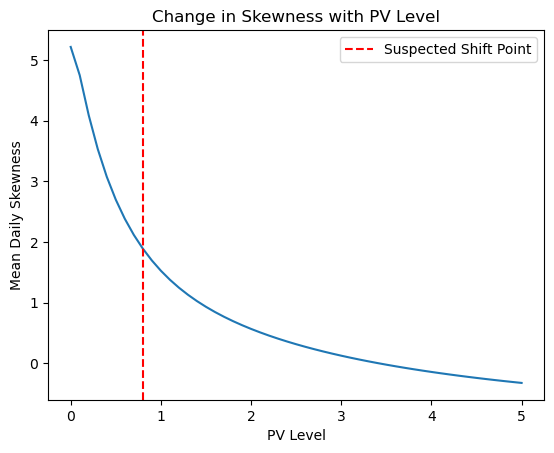

In [138]:
import matplotlib.pyplot as plt

mean_skew_per_pv = []  # Mean skewness per PV level
kw_means = {kw: [np.mean(results_c1[kw][kwp]) for kwp in results_c1[kw]] for kw in results_c1}
plt.plot(pv_levels, kw_means[0],linestyle='-')
plt.xlabel("PV Level")
plt.ylabel("Mean Daily Skewness")
plt.title("Change in Skewness with PV Level")
plt.axvline(x=0.8, color='r', linestyle="--", label="Suspected Shift Point")  # Adjust based on results
plt.legend()
plt.show()


The skewness of a daily profile decreases untill the charger kw becomes higher than the mean daily consumption

In [175]:
print('H0: The skewness does not change with EV')
skew_c1 = {}
skew_c2 = {}
skew_c3 = {}
kurt_c1 = {}
kurt_c2 = {}
kurt_c3 = {}
mean_c1 = {}
mean_c2 = {}
mean_c3 = {}

for kw in kw_set:
    daily_skew_c1 = profiles_c1[kw][kwp].skew(axis=0)
    daily_skew_c2 = profiles_c2[kw][kwp].skew(axis=0)
    daily_skew_c3 = profiles_c3[kw][kwp].min(axis=0)
    skew_c1[kw] = daily_skew_c1
    skew_c2[kw] = daily_skew_c2
    skew_c3[kw] = daily_skew_c3
    daily_mean_c1 = profiles_c1[kw][kwp].mean(axis=0)
    daily_mean_c2 = profiles_c2[kw][kwp].mean(axis=0)
    daily_mean_c3 = profiles_c3[kw][kwp].mean(axis=0)
    mean_c1[kw] = daily_mean_c1
    mean_c2[kw] = daily_mean_c2
    mean_c3[kw] = daily_mean_c3


H0: The skewness does not change with EV


In [262]:
skewness_values = [5, 4, 3, 2, 1, 3, 4, 5]
kw_levels = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
diff = np.diff(skewness_values)
if np.any(diff > 0):
    turning_index = np.where(diff > 0)[0][0] - 10
    if turning_index < 0: turning_index = 0
else: len(kw_levels) - 1
print(turning_index)
turning_point = kw_levels[turning_index] # charger kw at which skew starts increasing
print(turning_point)

0
1


Lowest skew when 

In [482]:
# # Compute skewness for each charger kW level and each profile
# # skewness_profiles = []
# from scipy.stats import wilcoxon

# kw_levels = list(profiles_c1.keys())
# differences = []
# differences2 = []
# skewness_values_before = []
# skewness_values_after = []
# skewness_values_turn = []
# for day in range(1,366): # per profile = 1 day of consumer 1
#     skewness_values = [] # Skew per kw
#     max_consumption = [] # Mean per kw
#     new_max = []
#     for kw in kw_levels:
#         load_profile = profiles_c1[kw][0][day] # profile = column = day
#         skewness_values.append(load_profile.skew())
#         new_max.append(profiles_c1[kw][0][day].max())
#         # mean_consumption.append(load_profile.mean())    
#         max_consumption.append(profiles_c1[0][0][day].max())    # Peak of base

#     # Find turning point (first index where skewness increases after decreasing)
#     # If the skewness starts increasing after decreasing, diff will contain positive values where the increase happens.
#     diff = np.diff(skewness_values)
#     window_size = 10
#     smoothed_values = list(np.convolve(skewness_values, np.ones(window_size)/window_size, mode='valid'))
#     # Select index where skewness starts increasing, if no increase: select last element
#     #turning_index = np.where(diff > 0)[0][0] if np.any(diff > 0) else len(kw_levels) - 1
#     # if np.any(diff > 0):
#     #     turning_index = np.where(diff > 0)[0][0] - 2
#     #     if turning_index < 0: turning_index = 0
#     # else: len(kw_levels) - 1

#     turning_index = smoothed_values.index(min(smoothed_values))
#     turning_point = kw_levels[turning_index] # charger kw at which skew starts increasing
#     #differences.append(turning_point/4 - mean_consumption[turning_index]) 
#     differences.append((turning_point)/4 - max_consumption[0]) 
#     index_greater = next((i for i, (a, b) in enumerate(zip(new_max, max_consumption)) if a > b), None)
#     differences2.append(turning_point/4 - kw_levels[index_greater])
#     # find charger kw at which charger kw > mean
#     # Find the index where list1 becomes greater than list2

#     # kw_levels_kwh = [x/4 for x in kw_levels]
#     # index = next((i for i, (a, b) in enumerate(zip(kw_levels, mean_consumption)) if a > b), None)
#     # skew_value_before = skewness_values[index-1]
#     # skew_value_after = skewness_values[index+1]
#     # skew_at_turn = skewness_values[index]
#     # skewness_values_before.append(skew_value_before)
#     # skewness_values_after.append(skew_value_after)
#     # skewness_values_turn.append(skew_at_turn)


# # check for normality
# from scipy.stats import kstest, norm

# stat, p_value = kstest(differences, 'norm', args=(np.mean(differences), np.std(differences)))

# print(f"KS Test Statistic: {stat:.5f}, p-value: {p_value:.5f}")

# # Perform Wilcoxon signed-rank test to check if turning points are significantly higher than mean consumption
# # Checks whether the median difference between paired observations is zero
# # turning point (charger kw) > mean consumption
# w_stat, p_value = wilcoxon(differences, alternative="two-sided")
# # Output results
# print(f"Wilcoxon signed-rank test statistic: {w_stat:.3f}")
# print(f"P-value: {p_value}")
# # Interpretation
# if p_value < 0.05:
#     print("Statistically significant: Difference between max consumption and charger kW at which skew is minimal is NOT zero.")
# else:
#     print("Not statistically significant: Difference between max consumption and charger kW at which skew is minimal is zero.")
# print(differences)
# # Calculate the confidence interval (e.g., 95%)
# mean_diff = np.mean(differences)
# std_diff = np.std(differences, ddof=1)
# n = len(differences)
# from scipy import stats
# # 95% Confidence interval
# conf_interval = stats.t.interval(0.95, n-1, loc=mean_diff, scale=std_diff/np.sqrt(n))
# print("Confidence interval:", conf_interval)

# print(differences2)
# w_stat, p_value = wilcoxon(differences2, alternative="two-sided")
# # Output results
# print(f"Wilcoxon signed-rank test statistic: {w_stat:.3f}")
# print(f"P-value: {p_value}")
# # Interpretation
# if p_value < 0.05:
#     print("Statistically significant: Difference between kw where max consumption > max base and charger kW at which skew is minimal is NOT zero.")
# else:
#     print("Not statistically significant: Difference between max consumption and charger kW at which skew is minimal is zero.")

# w_stat, p_value = wilcoxon(differences, alternative="two-sided")
# print(f"Wilcoxon signed-rank test statistic: {w_stat:.3f}")
# print(f"P-value: {p_value}")
# # Interpretation
# if p_value < 0.05:
#     print("Statistically significant: The turning point in skewness consistently occurs when charger kW = mean daily consumption.")
# else:
#     print("Not statistically significant: The turning point does not consistently occur when charger kw = mean daily consumption.")


# # Option 2: test skew before and after charger kw > daily consumption => confirms dip at chargerkw > mean consumption
# # greater: d = x-y > 0 => y < x
# # test if skew values before are greater than at charger kw

# # stat, p1 = wilcoxon(skewness_values_before, skewness_values_turn, alternative="greater")
# # print(f"Wilcoxon signed-rank test statistic: {w_stat:.3f}")
# # print(f"P-value: {p_value:.5f}")
# # # Interpretation
# # if p1 < 0.05:
# #     print("Statistically significant: The skewness values before charging>mean are consistently higher than after charging>mean.")
# # else:
# #     print("Not statistically significant.")

# # # test if skew values after are greater than at charger kw
# # stat, p2 = wilcoxon(skewness_values_after, skewness_values_turn, alternative="greater")
# # print(f"Wilcoxon signed-rank test statistic: {w_stat:.3f}")
# # print(f"P-value: {p_value:.5f}")
# # # Interpretation
# # if p2 < 0.05:
# #     print("Statistically significant: The skewness values after charging>mean are consistently higher than before charging>mean.")
# # else:
# #     print("Not statistically significant")

# # if p1<0.05 and p2<0.05:
# #     print("There is a dip in skewness when charger kw > mean consumption")
# # else:
# #     print("No dip when charger kw > mean consumption")

KS Test Statistic: 0.22906, p-value: 0.00000
Wilcoxon signed-rank test statistic: 32580.000
P-value: 0.7519296710428661
Not statistically significant: Difference between max consumption and charger kW at which skew is minimal is zero.
[-0.01599999999999996, 0.245, -0.01899999999999999, 0.008000000000000007, 0.05499999999999999, -0.126, -0.02999999999999997, 0.020999999999999963, -0.069, -0.418, -0.10699999999999998, -0.141, -0.118, -0.10800000000000001, 0.056999999999999995, 0.127, -0.184, -0.168, -0.13, 0.08100000000000002, -0.11199999999999999, -0.14, 0.31900000000000006, 0.7170000000000001, -0.13, -0.137, -0.049000000000000016, -0.15000000000000002, -0.143, -0.17000000000000004, -0.18899999999999995, -0.17200000000000001, 0.07400000000000001, -0.045999999999999985, -0.181, -0.104, -0.33599999999999997, 0.6609999999999999, -0.030000000000000027, 0.29899999999999993, -0.15600000000000003, 0.10299999999999998, -0.10400000000000004, -0.27999999999999997, -0.02200000000000002, -0.1550000

Significant difference in skew values before and after a point

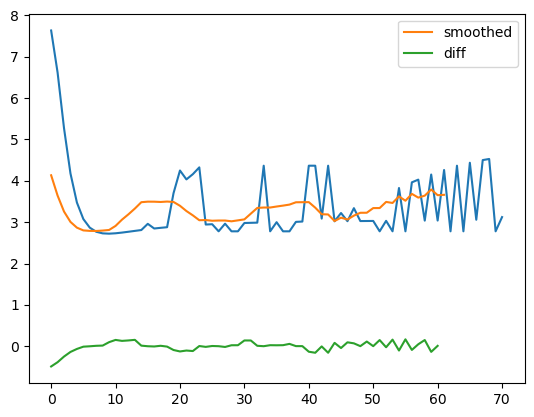

In [443]:
kw_levels = list(profiles_c1.keys())
differences = []
skew = []
for day in range(1,366): # per profile = 1 day of consumer 1
    skewness_values = [] # Skew per kw
    mean_day_cons = [] # Mean per kw
    for kw in kw_levels:
        load_profile = profiles_c1[kw][0][day] # profile = column = day
        skewness_values.append(load_profile.skew())
    diff = np.diff(skewness_values)
    index = None
    for i in range(1, len(diff)):
        if diff[i] > diff[i - 1]:  # Compare with the previous value
            index = i
            break 
    skew.append(skewness_values)
skewtest=skew[12]
plt.plot(skewtest) 

window_size=10
smoothed_values = np.convolve(skewtest, np.ones(window_size)/window_size, mode='valid')
plt.plot(smoothed_values, label = 'smoothed')
diff = np.diff(smoothed_values)
plt.plot(diff,label='diff')
plt.legend()

In [412]:
# Compute skewness for each charger kW level and each profile
# skewness_profiles = []
from scipy.stats import wilcoxon

kwp_levels = list(profiles_c1[0].keys())
differences = []
skewness_values_before = []
skewness_values_after = []
for day in range(1,366): # per profile = 1 day of consumer 1
    skewness_values = [] # Skew per kw
    mean_day_cons = [] # Mean per kw
    for kwp in kwp_levels:
        load_profile = profiles_c1[0][kwp][day] # profile = column = day
        skewness_values.append(load_profile.skew())
        mean_day_cons.append(load_profile[24:80].mean()) 
    # Find point mean cons = 0
    indices = list(filter(lambda x: mean_day_cons[x] < 0 , range(len(mean_day_cons))))
    if indices == []: zero_cons_index = None
    else: 
        zero_cons_index = indices[0] 

    # Find point where decrease slows down
    diff = np.diff(skewness_values)
    index = None
    for i in range(1, len(diff)):
        if diff[i] > diff[i - 1]:  # Compare with the previous value
            index = i
            break  
    if index != None and index !=0 and zero_cons_index != None:
        zero_cons = kwp_levels[zero_cons_index]-0.1# kwp at which daily consumption < 0
        turning_point = kwp_levels[index-1]+0.1 # kwp at which skewness changes direction
        differences.append(zero_cons-turning_point)
print(len(differences))
print((differences))
# Perform the Wilcoxon signed-rank test
w_stat, p_value = wilcoxon(differences, alternative="two-sided")

# Output results
print(f"Wilcoxon signed-rank test statistic: {w_stat:.3f}")
print(f"P-value: {p_value}")

# Interpretation
alpha = 0.05  # Significance level
if p_value < alpha:
    print("Statistically significant: The turning point in skewness occurs when mean daily consumption reaches zero.")
else:
    print("Not statistically significant: The turning point does not exactly match the zero-consumption point.")


# Calculate the confidence interval (e.g., 95%)
mean_diff = np.mean(differences)
std_diff = np.std(differences, ddof=1)
n = len(differences)

from scipy import stats

# 95% Confidence interval
conf_interval = stats.t.interval(0.95, n-1, loc=mean_diff, scale=std_diff/np.sqrt(n))

print("Confidence interval:", conf_interval)

import matplotlib.pyplot as plt

# Plot a histogram of the differences
# plt.hist(differences, bins=30)
# plt.title("Histogram of Differences")
# plt.xlabel("Difference")
# plt.ylabel("Frequency")
# plt.axvline(x=0, color='r', linestyle='--')  # Zero line
# plt.show()


340
[0.6999999999999998, -0.7000000000000002, 1.5999999999999996, 0.5999999999999999, 1.4, 1.0999999999999996, 1.0999999999999999, 0.9, 2.7, 0.7, 1.0, 0.8999999999999999, 0.9999999999999996, 0.7, 0.7, 0.5, 0.4999999999999998, 0.8999999999999997, -0.8000000000000002, 0.5999999999999999, 2.3, 2.1999999999999997, 0.6, 0.4999999999999999, 1.6, 0.2999999999999998, 0.5999999999999996, 0.4, -0.10000000000000006, -0.29999999999999993, 0.2999999999999998, 0.09999999999999987, 0.10000000000000053, 0.30000000000000004, 1.9999999999999996, 0.09999999999999998, 0.8000000000000003, 0.5, 0.3999999999999997, 0.09999999999999998, 0.19999999999999996, 0.0, 0.0, -2.7755575615628914e-17, -0.09999999999999998, 0.20000000000000007, -0.09999999999999998, -0.10000000000000006, -0.19999999999999996, -0.10000000000000006, -0.30000000000000004, 0.0, 0.0, -2.7755575615628914e-17, -0.1, 0.0, 0.0, 0.09999999999999998, -0.5, 0.09999999999999964, 0.30000000000000004, -0.7, 0.10000000000000003, -2.7755575615628914e-17

In [385]:
t= 1.962
differences = pd.Series(differences)
print(differences.mean()+(t*(differences.std(ddof=1)/np.sqrt(len(differences)))))


0.19704991711783218


In [176]:
for kw in kw_set:
    # Get the skewness and mean consumption for each profile
    daily_skew_c1 = skew_c1[kw]
    daily_skew_c2 = skew_c2[kw]
    daily_skew_c3 = skew_c3[kw]
    daily_mean_c1 = mean_c1[kw]
    daily_mean_c2 = mean_c2[kw]
    daily_mean_c3 = mean_c3[kw]
        
    # Identify where the skewness changes direction (starts increasing again after decreasing)
    if kw > daily_mean_c1:
        skew_after_threshold_c1.append(daily_skew_c1)
    else:
        skew_before_threshold_c1.append(daily_skew_c1)
    
    if kw > daily_mean_c2:
        skew_after_threshold_c2.append(daily_skew_c2)
    else:
        skew_before_threshold_c2.append(daily_skew_c2)
    
    if kw > daily_mean_c3:
        skew_after_threshold_c3.append(daily_skew_c3)
    else:
        skew_before_threshold_c3.append(daily_skew_c3)


alpha = 0.05
for kwp in kwp_set:
    h_stat1, p_value1 = kruskal(*results_c1[kwp])
    h_stat2, p_value2 = kruskal(*results_c2[kwp])
    h_stat3, p_value3 = kruskal(*results_c3[kwp])

    #print(f"PV Level {kwp}: H-statistic = {h_stat}, p-value = {p_value}")    
    if p_value1 < alpha:
        print(f"Consumer 1: Reject H0 for {kwp} PV => significant difference in minimum load.")
    # else:
    #     print("Fail to reject H0 => no significant difference in minimum load.")
    if p_value2 < alpha:
        print(f"Consumer 2: Reject H0 for {kwp} PV => significant difference in minimum load.")
    if p_value3 < alpha:
        print(f"Consumer 3: Reject H0 for {kwp} PV => significant difference in minimum load.")
print("Done")    

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import skew, mannwhitneyu
import matplotlib.pyplot as plt

# Assuming you have daily profile data for each day
# Example structure: Each entry in the `daily_profiles` list is a daily profile
# Charger kW values from 0 to 5 in 0.1 steps
charger_kW_values = np.arange(0, 5.1, 0.1)  

# Placeholder for storing skewness values for each profile at each charger kW
all_skewness_values = []

# Loop through each daily profile (replace this with actual data)
for daily_profile in daily_profiles:  # daily_profiles is a list of profiles
    skew_values = []
    mean_consumption = np.mean(daily_profile)  # Calculate mean consumption for the profile
    
    # Calculate skewness for each charger kW
    for charger_kW in charger_kW_values:
        # Add charging profile to the daily profile
        charging_profile = np.full_like(daily_profile, charger_kW)  # Simulated charging profile (constant charging)
        combined_profile = daily_profile + charging_profile  # Daily + charging profile
        
        # Calculate skewness for the combined profile
        skew_values.append(skew(combined_profile))
    
    all_skewness_values.append({
        'daily_profile': daily_profile, 
        'skew_values': skew_values, 
        'mean_consumption': mean_consumption
    })
    
# Identify when skewness starts to increase
thresholds = []  # Store the threshold values (where skewness starts increasing again)
for entry in all_skewness_values:
    skew_values = entry['skew_values']
    mean_consumption = entry['mean_consumption']
    
    # Identify where the skewness changes direction (start increasing after decreasing)
    threshold_kW = None
    for i in range(1, len(skew_values) - 1):
        if skew_values[i - 1] > skew_values[i] and skew_values[i] < skew_values[i + 1]:
            if charger_kW_values[i] > mean_consumption:
                threshold_kW = charger_kW_values[i]
                break
    
    thresholds.append(threshold_kW)

# Now perform statistical tests (e.g., Mann-Whitney U test) for each profile
p_values = []
for entry in all_skewness_values:
    skew_values = entry['skew_values']
    mean_consumption = entry['mean_consumption']
    
    # Split the skewness values into two groups based on the mean consumption
    below_threshold = [sk for i, sk in enumerate(skew_values) if charger_kW_values[i] <= mean_consumption]
    above_threshold = [sk for i, sk in enumerate(skew_values) if charger_kW_values[i] > mean_consumption]
    
    # Perform Mann-Whitney U test
    stat, p_value = mannwhitneyu(below_threshold, above_threshold, alternative='two-sided')
    p_values.append(p_value)
    
# Interpret results
for i, p_value in enumerate(p_values):
    if p_value < 0.05:
        print(f"Profile {i+1}: The skewness before and after the threshold charger kW is significantly different (p-value = {p_value:.3f}).")
    else:
        print(f"Profile {i+1}: The skewness before and after the threshold charger kW is not significantly different (p-value = {p_value:.3f}).")


Test

In [166]:
print(np.random.uniform(-1, 1))  # Placeholder for actual skewness values


-0.7780038024173703
